# Import Library

In [1]:
!pip install Sastrawi
!pip install emoji

In [96]:
import pandas as pd
import numpy as np
import re
import string
import emoji
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import csv
import requests
from io import StringIO
nltk.download('punkt_tab')
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML dicoding/pengembangan ml/NLP/analisis sentimen/submission/ulasan_jobstreet.csv')
df

,Review
0,"Aplikasinya sudah cukup bagus dan membantu, ta..."
1,"Jobstreet dulu bagus, akses aplikasinya ringan..."
2,"Awal-awal aplikasinya berjalan baik, tapi sete..."
3,Ganti bintang 2 dulu ya min. Semenjak di-updat...
4,parah aplikasi gabisa digunakan setiap mau log...
...,...
67631,👍
67632,🤔
67633,💩
67634,👎


# Pembersihan pertama

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67636 entries, 0 to 67635
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  67627 non-null  object
dtypes: object(1)
memory usage: 528.5+ KB


In [6]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN)
clean_df = df.dropna()

In [7]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

In [8]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36457 entries, 0 to 67635
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  36457 non-null  object
dtypes: object(1)
memory usage: 569.6+ KB


# Preprocessing Text

In [9]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Hapus mention (@username)
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'RT[\s]', '', text)  # Hapus RT
    text = re.sub(r'http\S+', '', text)  # Hapus link
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = emoji.replace_emoji(text, replace='')  # Hapus emoji
    text = re.sub(r'[^\w\s]', ' ', text)  # Hapus tanda baca
    text = re.sub(r'\b\w{1}\b', '', text)  # Hapus kata satu huruf
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berlebih
    return text

def casefoldingText(text):
    return text.lower()  # Ubah ke huruf kecil

def tokenizingText(text):
    return word_tokenize(text)  # Tokenisasi pakai nltk

def filteringText(words):
    listStopwords = set(stopwords.words('indonesian') + stopwords.words('english'))

    # Stopword tambahan
    additional_stopwords = {"iya", "yaa", "gak", "nya", "na", "sih", "ku", "di", "ga", "ya",
                            "gaa", "loh", "kah", "woi", "woii", "woy", "ke", "yg", "dan",
                            "yang", "lah", "ya", "deh", "ini", "dong", "gak", "inii", "huhuuu",
                            "ga", "pun", "yahoo", "min", "d", "eh", "pas", "kok", "donk",
                            "pler", "nge", "t*koped*a", "linkedin", "lo", "sue", "dahhh",
                            "wakwaaaw", "euy", "si", "anu", "mboten", "aamiin", "smg", "semoga", "allah","aamiin", "yuk", "alaamiin",
                            "moga", "zzzz", "bismillah", "mudahan", "aju", "robbal", "alamiin",
                            "barokah", "aalamiin","amiiiin"}

    listStopwords.update(additional_stopwords)  # Update tanpa duplikasi
    return [word for word in words if word not in listStopwords]

# Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemmingText(words):
    return [stemmer.stem(word) for word in words]

# memperbaiki kata yang tidak benar
slangwords = {
    "sig": "sign",
    "ok": "oke",
    "tp": "tapi",
    "jd": "jadi",
    "sy": "saya",
    "mo": "mau",
    "dgn": "dengan",
    "dg": "dengan",
    "lg": "lagi",
    "klo": "kalo",
    "bgt": "banget",
    "bener": "benar",
    "krn": "karena",
    "tdk": "tidak",
    "trs": "terus",
    "mksh": "terima kasih",
    "dsb": "dan sebagainya",
    "udh": "sudah",
    "blm": "belum",
    "td": "tadi",
    "sm": "sama",
    "lg": "lagi",
    "dr": "dari",
    "tp": "tapi",
    "jg": "juga",
    "ad": "ada",
    "payahh": "payah",
    "parahhhh": "parah",
    "bjsa": "bisa",
    "terusssss": "terus",
    "org": "orang",
    "stelah": "setelah",
    "perushaan": "perusahaan",
    "ttd": "tanda tangan",
    "matrai": "materai",
    "lagiii": "lagi",
    "telogout": "keluar",
    "sdhasukkan": "sudah masukkan",
    "tisak": "tidak",
    "uda": "sudah",
    "bet": "banget",
    "gw": "saya",
    "sd": "sampai dengan",
    "ttep": "tetap",
    "dll": "dan lain lain",
    "pdhal": "padahal",
    "mnit": "menit",
    "lowong": "lowongan",
    "kmrn": "kemarin",
    "sy": "saya",
    "krg": "kurang",
    "skrg": "sekarang",
    "skrng": "sekarang",
    "slain": "selain",
    "bs": "bisa",
    "utk": "untuk",
    "ga": "tidak",
    "gmna": "bagaimana",
    "gmn": "bagaimana",
    "ok": "oke",
    "apk": "aplikasi",
    "dpt": "dapat",
    "ttp": "tetap",
    "sya": "saya",
    "tpi": "tapi",
    "anehhhhh": "aneh",
    "pc": "komputer",
    "semangkjn": "semakin",
    "aply": "apply",
    "cpt": "cepat",
    "gajih": "gaji",
    "okok": "oke",
    "mantab": "mantap",
    "mantabs": "mantap",
    "mntap": "mantap",
    "manta p": "mantap",
    "bagu": "bagus",
    "Bgus": "bagus",
    "bnget": "banget",
    "blum": "belum"
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords.get(word.lower(), word) for word in words]
    return ' '.join(fixed_words)

def toSentence(words):
    if isinstance(words, list):
        return ' '.join(words)
    return words  # Jika bukan list, kembalikan apa adanya

In [10]:
clean_df['text_clean'] = clean_df['Review'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# mengganti kata-kata menjadi kata dasar dan menyimpannya di 'text_stemming'
clean_df['text_stemming'] = clean_df['text_stopword'].apply(stemmingText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stemming'].apply(toSentence)

In [11]:
clean_df

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir
0,"Aplikasinya sudah cukup bagus dan membantu, ta...",Aplikasinya sudah cukup bagus dan membantu tap...,aplikasinya sudah cukup bagus dan membantu tap...,aplikasinya sudah cukup bagus dan membantu tap...,"[aplikasinya, sudah, cukup, bagus, dan, memban...","[aplikasinya, bagus, membantu, developer, tolo...","[aplikasi, bagus, bantu, developer, tolong, si...",aplikasi bagus bantu developer tolong sign daf...
1,"Jobstreet dulu bagus, akses aplikasinya ringan...",Jobstreet dulu bagus akses aplikasinya ringan ...,jobstreet dulu bagus akses aplikasinya ringan ...,jobstreet dulu bagus akses aplikasinya ringan ...,"[jobstreet, dulu, bagus, akses, aplikasinya, r...","[jobstreet, bagus, akses, aplikasinya, ringan,...","[jobstreet, bagus, akses, aplikasi, ringan, ka...",jobstreet bagus akses aplikasi ringan kalo upd...
2,"Awal-awal aplikasinya berjalan baik, tapi sete...",Awal awal aplikasinya berjalan baik tapi setel...,awal awal aplikasinya berjalan baik tapi setel...,awal awal aplikasinya berjalan baik tapi setel...,"[awal, awal, aplikasinya, berjalan, baik, tapi...","[aplikasinya, berjalan, penggunaan, ko, masuk,...","[aplikasi, jalan, guna, ko, masuk, masukkin, e...",aplikasi jalan guna ko masuk masukkin email ny...
3,Ganti bintang 2 dulu ya min. Semenjak di-updat...,Ganti bintang dulu ya min Semenjak di update p...,ganti bintang dulu ya min semenjak di update p...,ganti bintang dulu ya min semenjak di update p...,"[ganti, bintang, dulu, ya, min, semenjak, di, ...","[ganti, bintang, semenjak, update, pake, otp, ...","[ganti, bintang, semenjak, update, pake, otp, ...",ganti bintang semenjak update pake otp susah l...
4,parah aplikasi gabisa digunakan setiap mau log...,parah aplikasi gabisa digunakan setiap mau log...,parah aplikasi gabisa digunakan setiap mau log...,parah aplikasi gabisa digunakan setiap mau log...,"[parah, aplikasi, gabisa, digunakan, setiap, m...","[parah, aplikasi, gabisa, log, otomatis, web, ...","[parah, aplikasi, gabisa, log, otomatis, web, ...",parah aplikasi gabisa log otomatis web banget ...
...,...,...,...,...,...,...,...,...
67627,.m,,,,[],[],[],
67629,Mantab. ....,Mantab,mantab,mantap,[mantap],[mantap],[mantap],mantap
67632,🤔,,,,[],[],[],
67633,💩,,,,[],[],[],


# Pembersihan kedua

In [12]:
# cek missing value dan nilai kosong
print(clean_df['text_akhir'].isna().sum())  # Cek jumlah nilai NaN
print(clean_df['text_akhir'].eq('').sum())  # Cek jumlah string kosong ('')

0
476


In [13]:
# menghapus nilai kosong dan missing values
clean_df = clean_df[clean_df['text_akhir'].notna() & clean_df['text_akhir'].ne('')]

In [14]:
clean_df

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir
0,"Aplikasinya sudah cukup bagus dan membantu, ta...",Aplikasinya sudah cukup bagus dan membantu tap...,aplikasinya sudah cukup bagus dan membantu tap...,aplikasinya sudah cukup bagus dan membantu tap...,"[aplikasinya, sudah, cukup, bagus, dan, memban...","[aplikasinya, bagus, membantu, developer, tolo...","[aplikasi, bagus, bantu, developer, tolong, si...",aplikasi bagus bantu developer tolong sign daf...
1,"Jobstreet dulu bagus, akses aplikasinya ringan...",Jobstreet dulu bagus akses aplikasinya ringan ...,jobstreet dulu bagus akses aplikasinya ringan ...,jobstreet dulu bagus akses aplikasinya ringan ...,"[jobstreet, dulu, bagus, akses, aplikasinya, r...","[jobstreet, bagus, akses, aplikasinya, ringan,...","[jobstreet, bagus, akses, aplikasi, ringan, ka...",jobstreet bagus akses aplikasi ringan kalo upd...
2,"Awal-awal aplikasinya berjalan baik, tapi sete...",Awal awal aplikasinya berjalan baik tapi setel...,awal awal aplikasinya berjalan baik tapi setel...,awal awal aplikasinya berjalan baik tapi setel...,"[awal, awal, aplikasinya, berjalan, baik, tapi...","[aplikasinya, berjalan, penggunaan, ko, masuk,...","[aplikasi, jalan, guna, ko, masuk, masukkin, e...",aplikasi jalan guna ko masuk masukkin email ny...
3,Ganti bintang 2 dulu ya min. Semenjak di-updat...,Ganti bintang dulu ya min Semenjak di update p...,ganti bintang dulu ya min semenjak di update p...,ganti bintang dulu ya min semenjak di update p...,"[ganti, bintang, dulu, ya, min, semenjak, di, ...","[ganti, bintang, semenjak, update, pake, otp, ...","[ganti, bintang, semenjak, update, pake, otp, ...",ganti bintang semenjak update pake otp susah l...
4,parah aplikasi gabisa digunakan setiap mau log...,parah aplikasi gabisa digunakan setiap mau log...,parah aplikasi gabisa digunakan setiap mau log...,parah aplikasi gabisa digunakan setiap mau log...,"[parah, aplikasi, gabisa, digunakan, setiap, m...","[parah, aplikasi, gabisa, log, otomatis, web, ...","[parah, aplikasi, gabisa, log, otomatis, web, ...",parah aplikasi gabisa log otomatis web banget ...
...,...,...,...,...,...,...,...,...
67522,Bintang ⭐⭐⭐⭐⭐,Bintang,bintang,bintang,[bintang],[bintang],[bintang],bintang
67619,Good............,Good,good,good,[good],[good],[good],good
67622,Ok.bgt..,Ok bgt,ok bgt,oke banget,"[oke, banget]","[oke, banget]","[oke, banget]",oke banget
67623,"Ok,,,ok",Ok ok,ok ok,oke oke,"[oke, oke]","[oke, oke]","[oke, oke]",oke oke


In [15]:
# mengidentifikasi duplikasi data pada clean_df setelah dilakukan pembersihan
print(clean_df['text_akhir'].duplicated().sum())

7981


In [16]:
# menghapus data duplikat setelah pembersihan
clean_df = clean_df.drop_duplicates(subset=['text_akhir'], keep='first')

In [17]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28000 entries, 0 to 67484
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Review                28000 non-null  object
 1   text_clean            28000 non-null  object
 2   text_casefoldingText  28000 non-null  object
 3   text_slangwords       28000 non-null  object
 4   text_tokenizingText   28000 non-null  object
 5   text_stopword         28000 non-null  object
 6   text_stemming         28000 non-null  object
 7   text_akhir            28000 non-null  object
dtypes: object(8)
memory usage: 1.9+ MB


# Eksplorasi kata

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

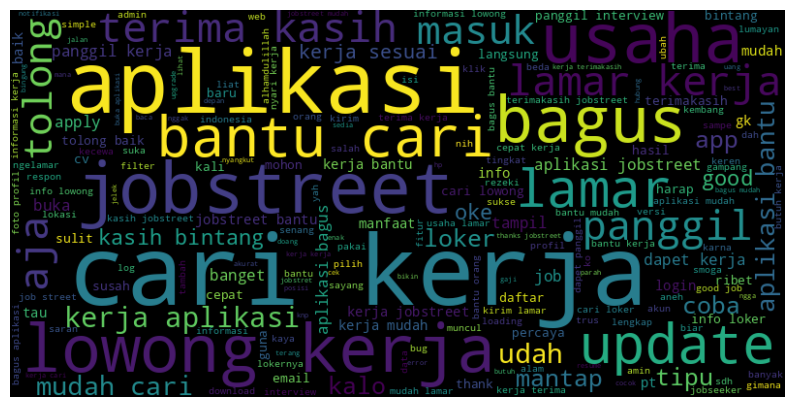

In [18]:
# Gabungkan semua teks menjadi satu string
all_text = ' '.join([' '.join(text) for text in clean_df['text_stemming']])

# Buat objek WordCloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=100).generate(all_text)

# Tampilkan wordcloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

kata: kerja, Frekuensi: 9908
kata: aplikasi, Frekuensi: 6334
kata: jobstreet, Frekuensi: 4373
kata: bantu, Frekuensi: 4327
kata: cari, Frekuensi: 4221
kata: lamar, Frekuensi: 3507
kata: mudah, Frekuensi: 2745
kata: usaha, Frekuensi: 2568
kata: panggil, Frekuensi: 2397
kata: bagus, Frekuensi: 2379


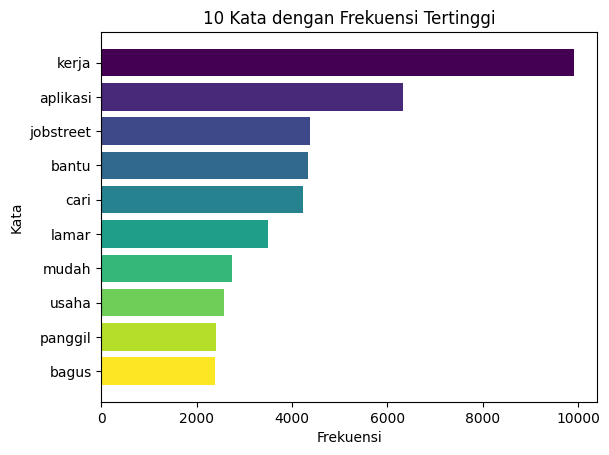

In [20]:
#Hitung frekuensi setiap kata
word_freq = Counter([word for text in clean_df['text_stemming'] for word in text])

for word, freq in word_freq.most_common(10):
  print(f'kata: {word}, Frekuensi: {freq}')

#Menyimpan hasil stopword removal data ke dalam DataFrame
result_df = pd.DataFrame({"Kata": [word for word, _ in word_freq.most_common()],
                          "Frekuensi": [freq for _, freq in word_freq.most_common()]})

#Hitung frekuensi setiap kata
word_freq = Counter([word for text in clean_df['text_stemming'] for word in text])

#Ambil 10 kata dengan frekuensi tertinggi
most_common_words = word_freq.most_common(10)

#Buat list untuk label dan frekuensi
labels, freq = zip(*most_common_words)

#Buat array warna acak
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

#Buat barplot horizontal dengan warna acak
plt.barh(labels, freq, color=colors)
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.title('10 Kata dengan Frekuensi Tertinggi')
plt.gca().invert_yaxis() # Balik urutan label di sumbu y
plt.show()

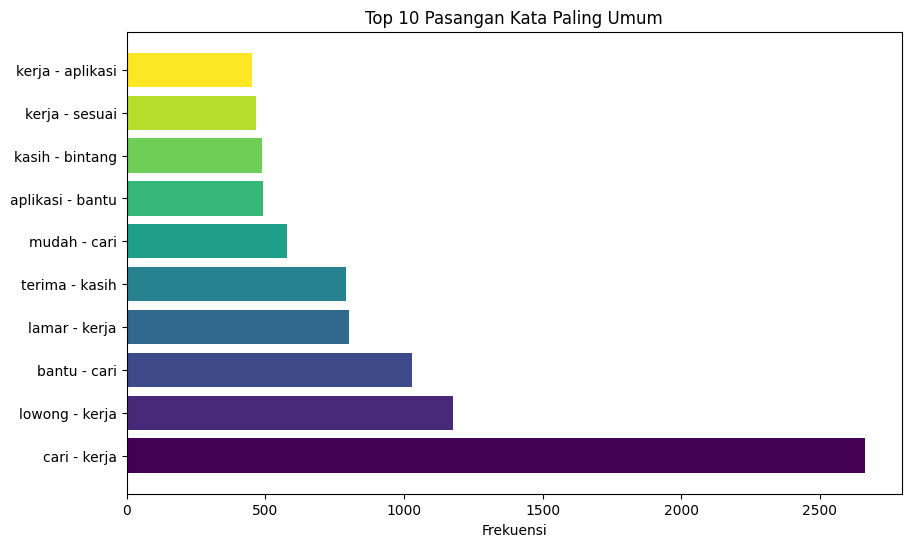

In [21]:
#Horizontal Bar Plot untuk Keterkaitan Kata
# Calculate word pair frequencies
pair_freq = Counter()
for text in clean_df['text_stemming']:
    for i in range(len(text) - 1):
        pair_freq[(text[i], text[i + 1])] += 1
# Existing plotting code below
common_pairs = pair_freq.most_common(10) #Ambil 10 pasangan kata paling umum
pairs, frequencies = zip(*common_pairs)

#Ubah pasangan kata menjadi string
pairs = [' - '.join(pair) for pair in pairs]

#Buat array warna acak
colors = plt.cm.viridis (np.linspace(0, 1, len(pairs)))

plt.figure(figsize=(10, 6))
plt.barh(pairs, frequencies, color=colors)
plt.xlabel('Frekuensi')
plt.title('Top 10 Pasangan Kata Paling Umum')

plt.show()

# Labeling

In [22]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [53]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    else:
        polarity = 'neutral'

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [54]:
# menghitung hasil labeling
results = clean_df['text_stemming'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    11720
positive    11372
neutral      4908
Name: count, dtype: int64


<ipython-input-54-611b876fcf0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['polarity_score'] = results[0]
<ipython-input-54-611b876fcf0e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['polarity'] = results[1]


In [55]:
clean_df

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir,polarity_score,polarity
0,"Aplikasinya sudah cukup bagus dan membantu, ta...",Aplikasinya sudah cukup bagus dan membantu tap...,aplikasinya sudah cukup bagus dan membantu tap...,aplikasinya sudah cukup bagus dan membantu tap...,"[aplikasinya, sudah, cukup, bagus, dan, memban...","[aplikasinya, bagus, membantu, developer, tolo...","[aplikasi, bagus, bantu, developer, tolong, si...",aplikasi bagus bantu developer tolong sign daf...,-19,negative
1,"Jobstreet dulu bagus, akses aplikasinya ringan...",Jobstreet dulu bagus akses aplikasinya ringan ...,jobstreet dulu bagus akses aplikasinya ringan ...,jobstreet dulu bagus akses aplikasinya ringan ...,"[jobstreet, dulu, bagus, akses, aplikasinya, r...","[jobstreet, bagus, akses, aplikasinya, ringan,...","[jobstreet, bagus, akses, aplikasi, ringan, ka...",jobstreet bagus akses aplikasi ringan kalo upd...,-8,negative
2,"Awal-awal aplikasinya berjalan baik, tapi sete...",Awal awal aplikasinya berjalan baik tapi setel...,awal awal aplikasinya berjalan baik tapi setel...,awal awal aplikasinya berjalan baik tapi setel...,"[awal, awal, aplikasinya, berjalan, baik, tapi...","[aplikasinya, berjalan, penggunaan, ko, masuk,...","[aplikasi, jalan, guna, ko, masuk, masukkin, e...",aplikasi jalan guna ko masuk masukkin email ny...,-17,negative
3,Ganti bintang 2 dulu ya min. Semenjak di-updat...,Ganti bintang dulu ya min Semenjak di update p...,ganti bintang dulu ya min semenjak di update p...,ganti bintang dulu ya min semenjak di update p...,"[ganti, bintang, dulu, ya, min, semenjak, di, ...","[ganti, bintang, semenjak, update, pake, otp, ...","[ganti, bintang, semenjak, update, pake, otp, ...",ganti bintang semenjak update pake otp susah l...,-14,negative
4,parah aplikasi gabisa digunakan setiap mau log...,parah aplikasi gabisa digunakan setiap mau log...,parah aplikasi gabisa digunakan setiap mau log...,parah aplikasi gabisa digunakan setiap mau log...,"[parah, aplikasi, gabisa, digunakan, setiap, m...","[parah, aplikasi, gabisa, log, otomatis, web, ...","[parah, aplikasi, gabisa, log, otomatis, web, ...",parah aplikasi gabisa log otomatis web banget ...,-3,negative
...,...,...,...,...,...,...,...,...,...,...
67444,Ok thnks,Ok thnks,ok thnks,oke thnks,"[oke, thnks]","[oke, thnks]","[oke, thnks]",oke thnks,2,positive
67445,Good gaming,Good gaming,good gaming,good gaming,"[good, gaming]","[good, gaming]","[good, gaming]",good gaming,5,positive
67461,Jobstreet lovers,Jobstreet lovers,jobstreet lovers,jobstreet lovers,"[jobstreet, lovers]","[jobstreet, lovers]","[jobstreet, lovers]",jobstreet lovers,4,positive
67478,Job new,Job new,job new,job new,"[job, new]","[job, new]","[job, new]",job new,0,neutral


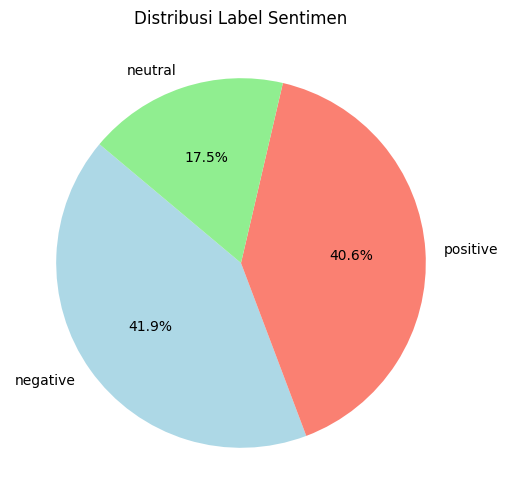

In [56]:
# Menghitung jumlah masing-masing label
label_counts = clean_df['polarity'].value_counts()

# Membuat pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'salmon', 'lightgreen'])
plt.title('Distribusi Label Sentimen')
plt.show()

# Modeling

## Deep learning (LSTM)

In [71]:
# Mengambil teks dan label
X = clean_df['text_akhir']
y = clean_df['polarity'].map({'positive': 2, 'neutral': 1, 'negative': 0})

# Tokenisasi dan konversi teks ke sekuens angka
max_words = 10000  # Jumlah maksimal kata dalam vocab
max_len = 100  # Maksimal panjang teks setelah padding

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Membagi dataset menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X_pad, np.array(y), test_size=0.2, random_state=42)

# One-hot encoding untuk 3 kelas
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Membangun Model LSTM
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Kompilasi Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping Callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1,
                           min_delta=0.01, baseline=0.95, restore_best_weights=True)

In [72]:
# Training Model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

Epoch 1/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 437s 613ms/step - accuracy: 0.7063 - loss: 0.6523 - val_accuracy: 0.8918 - val_loss: 0.3133
Epoch 2/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 442s 613ms/step - accuracy: 0.9229 - loss: 0.2180 - val_accuracy: 0.9211 - val_loss: 0.2356
Epoch 3/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 454s 630ms/step - accuracy: 0.9556 - loss: 0.1303 - val_accuracy: 0.9029 - val_loss: 0.2725
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.


In [73]:
# Evaluasi Model
# Evaluasi model di data training
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)

# Evaluasi model di data testing
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Cetak hasil
print(f"Akurasi pada Data Training: {train_acc:.2%}")
print(f"Akurasi pada Data Testing: {test_acc:.2%}")

Akurasi pada Data Training: 95.50%
Akurasi pada Data Testing: 92.11%


## Machine Learning

In [91]:
# Mengambil teks dan label
X = clean_df['text_akhir']
y = clean_df['polarity'].map({'positive': 2, 'neutral': 1, 'negative': 0})

### Skema 1: SVM + TF-IDF (80/20)

In [90]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000)

In [92]:
# Split Data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Transform
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train SVM
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_svm = svm_model.predict(X_test_tfidf)
print("SVM + TF-IDF (80/20) Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM + TF-IDF (80/20) Accuracy: 0.8825
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2365
           1       0.67      0.85      0.75       970
           2       0.94      0.89      0.91      2265

    accuracy                           0.88      5600
   macro avg       0.85      0.88      0.86      5600
weighted avg       0.90      0.88      0.89      5600



### Skema 2: Random Forest + TF-IDF (80/20)

In [85]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest + TF-IDF (80/20) Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest + TF-IDF (80/20) Accuracy: 0.8642857142857143
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2365
           1       0.86      0.75      0.80       970
           2       0.88      0.87      0.88      2265

    accuracy                           0.86      5600
   macro avg       0.87      0.84      0.85      5600
weighted avg       0.86      0.86      0.86      5600



### Skema 3: Random Forest + TF-IDF (70/30)

In [86]:
# Split Data (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# TF-IDF Transform
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Random Forest
rf_model_70_30 = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_model_70_30.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_rf_70_30 = rf_model_70_30.predict(X_test_tfidf)
print("Random Forest + TF-IDF (70/30) Accuracy:", accuracy_score(y_test, y_pred_rf_70_30))
print(classification_report(y_test, y_pred_rf_70_30))

Random Forest + TF-IDF (70/30) Accuracy: 0.8589285714285714
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3491
           1       0.85      0.74      0.79      1450
           2       0.88      0.86      0.87      3459

    accuracy                           0.86      8400
   macro avg       0.86      0.84      0.85      8400
weighted avg       0.86      0.86      0.86      8400



# SIMPAN MODEL

In [93]:
# Simpan model SVM
joblib.dump(svm_model, "svm_model.pkl")

# Simpan model Random Forest
joblib.dump(rf_model, "rf_model.pkl")

# Simpan TF-IDF Vectorizer (karena SVM & RF butuh ini buat inference)
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [95]:
# Simpan Model LSTM
model.save("lstm_model.h5")
print("Model LSTM berhasil disimpan!")

# Simpan Tokenizer (karena LSTM butuh ini buat inference)
joblib.dump(tokenizer, "tokenizer.pkl")
print("Tokenizer berhasil disimpan!")

Model LSTM berhasil disimpan!
Tokenizer berhasil disimpan!
